<a href="https://colab.research.google.com/github/sdsc-bw/Price_Intelligence/blob/main/Flat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatische Produktklassifizierung als Schlüsselelement zur Nachhaltigkeit im Umgang mit PIM Systemen.

<img src="images/ws_bg.png" style="width:800px; height:300px;">

Große e-Commerce Konzerne bauen bei der Artikelverwaltung auf maßgeschneiderte Produktinformationssysteme (PIM-Systeme), die mit propritären Produkt- und Strukturketten Hand in Hand arbeiten. Neue Produkte werden i.d.R. über Lieferantenlisten in das hauseigene PIM-System eingepflegt. Dies kann entweder durch regelbasierte Zuweisungen und oder durch von Hand-Eintragung durch Angestellte geschehen. Um diesen Prozess zu optimieren, Arbeitende zu entlasten und die Effizenz der hauseigenen IT-Systeme zu optimieren, gibt es unterschiedliche Ansätze für eine automatische Zuweisung von Artikeln aus Lieferantenlisten in die PIM-Struktur. 

Ein einfacher und unkomplizierter Ansatz für die taxonomische Klassifizierung ist die flache Klassifizierung - Flat Classification. Bei dieser geht es nicht um übergeordnete Kategorien. Klassifiziert wird jeder Artikel nach seiner endgültigen Bezeichnung auf Blattebene im zugrundeliegenden Graphen, der die PIM-Struktur darstellt. Der offensichtliche Vorteil dieses Ansatzes ist seine Einfachheit, die direkt mit einem einsetzbaren Klassifikator-Algorithmus umgesetzt werden kann.

<img src="images/bs_bg.png" style="width:800px; height:300px;">

Nachfolgend werden Gedankengänge für einen Vorreiter-Prozess eines Auto-Mappings auf Basis eines Flat-Classification Ansatzes dargestellt, der zum selbst ausprobieren verleiten sollen. Der Datensatz beinhaltet drei Spalten:
- Beschreibung
- Kurzbeschreibung
- Produktgruppe

Hier sollen die Beschreibungen in Verbindung mit NLP-Werkzeugen genutzt werden, um eine Klassifikation in die jeweilige Produktgruppe vorzunehmen.

Bereigestellt wurden die Daten durch die Price Intelligence GmbH. Unter [diesem Link](https://github.com/sdsc-bw/Price_Intelligence) können die Daten heruntergeladen werden, respektive kann dieses Repository geklont werden.

**Ablauf des Workshops:**
- Bereitstellung der notwendigen Daten und Pakete
- Visuelle Analyse
- Strategien für eine erweiterte Textverarbeitung ableiten
- Modellbildung
- Bereistellung der Metriken
- Anpassung der Strategien

Zu Beginn werden alle benötigten Pakete importiert nebst Download weiterer benötigter Daten wie zum Beispiel Stopp-Wörter.

In [2]:
import nltk
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import re
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rainer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rainer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Zunächst müssen die Daten in einem neuen Datenrahmen abgelegt und genauer betrachtet werden. Schließlich müssen grundlegende Entscheidungen über die Qualität von Beschreibung nebst Titel getroffen werden, um Folgeschritte besser planen zu können.

In [77]:
df_products = pd.read_csv(r'Ressources/eCom_Produkte.csv', sep=',', encoding='utf-8-sig', compression='zip')

In [79]:
df_products.head(10)

,Unnamed: 0,Beschreibung,Produktgruppe,Kurzbeschreibung
0,0,"Deckchair aus 100 % Polypropylen, PVC-frei und...",Stühle,"Deckchair, blau"
1,1,Renato Santi-Umhängetasche aus Leder mit Softm...,Taschen und Geldbörsen,"Umhängetasche, schwarz"
2,2,"von TOGETHER Oberteil aus Spitze, blickdicht g...",Damen-Kleider,"Kleid, koralle"
3,3,"Jacke: RH, 3/4-Arm mit Schlitz, am Ausschnitt ...",Damen-Sets Strick-/Jacke und Pullover,"Twinset, oliv-türkis"
4,4,"Anhänger mit 1 weißen Süßwasserzuchtperle, ca....",Anhänger,"Anhänger, GG 585 B"
5,5,Pullover durch Zierknöpfe am Ausschnitt geschm...,Damen-Pullover,"Pullover,blau"
6,6,SUPERGA-Schnürer 2750 Cotu Classic aus Canvas....,Halbschuhe,"Schnürschuh, rot"
7,7,"Blousonshirt, Hemdkragen, Knopfleiste, 3 Knöpf...",Herren-Shirts,"Blousonshirt,rosenholz"
8,8,"Damenring aus der Serie Firenze, mit mokkafarb...",Ringe,"Damenring, Edelstahl"
9,9,WALDLÄUFER-Schnürschuh aus Leder. Mit schönem ...,Halbschuhe,"Schnürschuh, weiß"


In der Spalte namens Produktgruppe sind Wörter hinterlegt. Der Einfachheit halber wird jeder Kateogorie eine Ganzzahl zugewiesen, um die Klassifizierung des Vorhersagemodells durch eine **Produkt ID** zu vereinfachen.

In [10]:
df_products['Produkt_ID'] = df_products['Produktgruppe'].factorize()[0]
df_products.head(2)

,Beschreibung,Produktgruppe,Kurzbeschreibung,Produkt_ID
0,"Deckchair aus 100 % Polypropylen, PVC-frei und...",Stühle,"Deckchair, blau",0
1,Renato Santi-Umhängetasche aus Leder mit Softm...,Taschen und Geldbörsen,"Umhängetasche, schwarz",1


Zur Vergewisserung wie viele Daten enthalten sind, wird per shape Funktion die Gesamtzahl nebst verfügbarer Spalten plakativ dargestellt.

In [11]:
df_products.shape

(101516, 4)

Die Gesamtzahl der Datenpunkte ist in wenigen Fälle ein guter Indikator für ein gutes Modell. Wichtig in diesem Beispiel ist, wie viel Daten (Artikel) pro Produktgruppe zur Verfügung stehen und ob die Verteilung der Artikel auf die Produktgruppen homogen ist. Daher finden wir zunächst heraus wie viel Produktgruppen wir überhaupt in den Daten finden:

In [12]:
df_products['Produktgruppe'].nunique()

441

Die zuvor ermittelten Produktgruppen allesamt visuell darzustellen würde wenig Sinn machen. Interessanter wird die Darstellung, wenn die jeweils vorhandenen Artikel innerhalb der Produktgruppen durch Bereiche repräsentiert werden. Ebenso lassen sich gezielt die 30 Produktgruppen darstellen mit den höchsten Artikeln.

In [13]:
df_products_threshold = df_products['Produktgruppe'].value_counts()[:30]
df_products_threshold

Damen-Shirts                  7959
Damen-Blusen                  5402
Damen-Hosen                   4570
Damen-Pullover                3873
Damen-Kleider                 3334
Damen-Jacken                  2839
BHs                           2257
Ketten                        2127
Damen-Jeans                   1895
Lampen und Leuchten           1877
Bettwäsche                    1809
Taschen und Geldbörsen        1729
Herren-Shirts                 1557
Halbschuhe                    1547
Damen-Strickjacken            1494
Damen-Tops                    1483
Polstermöbel                  1434
Figuren und Skulpturen        1434
Armschmuck und Fußkettchen    1353
Damen-Blazer                  1319
Tücher und Schals             1285
Damen-Röcke                   1239
Dekokissen                    1193
Anhänger                      1192
Unterhosen                    1189
Teppiche, Läufer, Schmufa     1150
Herren-Hosen                  1105
Ohrringe                      1031
Sandalen            

Es zeigt sich, dass bereits innerhalb der ersten 30 Kategorien ein rapider Abfall der zur Verfügung stehenenden Artikel pro Kategorie stattfindet.

In [14]:
threshold = 964 
df_products_underrepresented = (df_products['Produktgruppe'].value_counts() < threshold)
df_products_underrepresented.sum()

411

Wir benutzen daher nur die zuvor aufgezeigten 30 Produktgruppen.

In [15]:
df_products_used = df_products[df_products.groupby('Produktgruppe')['Produktgruppe'].transform('size')>threshold].reset_index(drop=True)

In [16]:
df_products_used.shape

(61702, 4)

In [17]:
df_products_used['Produktgruppe'].value_counts()

Damen-Shirts                  7959
Damen-Blusen                  5402
Damen-Hosen                   4570
Damen-Pullover                3873
Damen-Kleider                 3334
Damen-Jacken                  2839
BHs                           2257
Ketten                        2127
Damen-Jeans                   1895
Lampen und Leuchten           1877
Bettwäsche                    1809
Taschen und Geldbörsen        1729
Herren-Shirts                 1557
Halbschuhe                    1547
Damen-Strickjacken            1494
Damen-Tops                    1483
Polstermöbel                  1434
Figuren und Skulpturen        1434
Armschmuck und Fußkettchen    1353
Damen-Blazer                  1319
Tücher und Schals             1285
Damen-Röcke                   1239
Dekokissen                    1193
Anhänger                      1192
Unterhosen                    1189
Teppiche, Läufer, Schmufa     1150
Herren-Hosen                  1105
Ohrringe                      1031
Sandalen            

### Weitere Strategien
Die Annahme ist bestätigt, dass 411 Produktgruppen merklich weniger Artikel für das später folgende Modelltraining beinhalten, Sie können der Stelle andere Strategien verfolgen und entweder einzelne und oder andere Gruppierungen von Produktgruppen vornehmen.

Nichtsdestotrotz ist es nun an der Zeit gezielt eine Artikelbeschriebung zu betrachten, um Strategien für die Verarbeitung abzuleiten. Nachfolgend wird wahllos eine Beschreibung dargestellt.

In [18]:
df_products_used['Beschreibung'][9]

'Jomos-Schnürschuh aus genarbtem Nappaleder. Schaftrand- und Laschenpolsterung. Hoher Tragekomfort durch Lederfutter und auswechselbare, leicht gepolsterte Lederdecksohle. Flexibellaufsohle. Bequemweite H. in 4 Farben herren'

Es lässt sich ableiten, dass die Artikelbeschreibungen keiner bestimmten Norm folgen, die eine einheitliche Vorverarbeitung merklich vereinfachen würden. Nachfolgend wollen wir die jeweiligen Beschreibungstexte genauer unter die Lupe nehmen und erstellen eine neue Spalte, die jeweils die Zahl der genutzten Zeichen der Artikelbschreibung beinhaltet. Wir konvertieren hierzu die Beschreibungen in Strings und zählen die Buchstaben jeder Beschreibung, damit die Summe der Buchstaben in einer neuen Spalte nahmens Zeichenanzahl hinterlegt wird.

In [19]:
df_products_used['Beschreibung'] = df_products_used['Beschreibung'].astype(str)
df_products_used['Zeichenanzahl'] = df_products_used['Beschreibung'].apply(len)
df_products_used.sort_values(by='Zeichenanzahl', ascending=False).head(10)

,Beschreibung,Produktgruppe,Kurzbeschreibung,Produkt_ID,Zeichenanzahl
40791,"Ecksofa 'Genova' B293xT160xH88 cm, ca. 94,5kg ...",Polstermöbel,Ecksofa rechts schwarz,56,1826
40787,"Ecksofa 'Genova' B293xT160xH88 cm, ca. 94,5kg ...",Polstermöbel,Ecksofa links schwarz,56,1826
50853,"Impressionen living Kuschelsofa, taupe Materia...",Polstermöbel,"Kuschelsofa, taupe",56,1811
50137,"Palmen-Armband, Glanz, Länge ca. 15,5 cm, mit ...",Armschmuck und Fußkettchen,"Palmen-Armband,925 ver",55,1771
50145,"Palmen-Armband, Glanz, Länge ca. 15,5 cm, mit ...",Armschmuck und Fußkettchen,"Palmen-Armband, 925",55,1756
50201,"Herz-Collier, Glanz, Länge ca. 45 cm, Federrin...",Ketten,"Herz-Collier, 925 verg",46,1745
50230,"Stern-Collier, Glanz, Länge ca. 45 cm, Federri...",Ketten,"Stern-Collier,925 verg",46,1735
40801,"Ecksofa 'Genova' B293xT160xH88 cm, ca. 94,5kg ...",Polstermöbel,Ecksofa rechts weiß,56,1730
40802,"Ecksofa 'Genova' B293xT160xH88 cm, ca. 94,5kg ...",Polstermöbel,Ecksofa links weiß,56,1730
50148,"Flamingo-Armband, Glanz, Länge ca. 15,5 cm, mi...",Armschmuck und Fußkettchen,"Flamingo-Armband,925 r",55,1724


Wir können dem Modell positiv entgegenwirken, indem wir die Artikelbeschreibungen formatieren. Hierzu setzen wir eine neue Methode auf, die alle Wörter in Kleinschreibung konvertiert, Sonderzeichen löscht und Buchstaben löscht, die einzeln oder zu zweit vorhanden sind aber nicht als Stopp-Wörter gesehen werden.
Nun kann es vorkommen, dass durch das Aufäumen des Texts einzelne Buchstaben oder zwei Buchstaben vorhanden sind, die nicht durch die Stoppwörter entfernt werden. Sie können hier noch einen weiteren Ausdruck einfügen, um diese zu entfernen.

In [20]:
def vorverarbeitung(words):
    words = re.sub("[^A-Za-zäÄöÖüÜß]", " ", words)
    words = re.sub("ö", "oe", words)
    words = re.sub("ä", "ae", words)
    words = re.sub("ü", "ue", words)
    words = re.sub("Ö", "Oe", words)
    words = re.sub("Ä", "Ae", words)
    words = re.sub("Ü", "Ue", words)
    words = re.sub("ß", "ss", words)
    words = re.sub(r'\b\w{1,2}\b', " ", words)
    text = words.lower().split()

    return " ".join(text)

In [21]:
df_products_used['Beschreibung_Sauber'] = df_products_used['Beschreibung'].apply(vorverarbeitung)

In [22]:
df_products_used['Beschreibung_Sauber'][9]

'jomos schnuerschuh aus genarbtem nappaleder schaftrand und laschenpolsterung hoher tragekomfort durch lederfutter und auswechselbare leicht gepolsterte lederdecksohle flexibellaufsohle bequemweite farben herren'

Jetzt können wir uns aus dem Standard-Repertoire an Werkzeugen bedienen. Zunächst können die Stoppwörter aus den Artikelbeschreibungen entfernt werden, um den rohen Informationsgehalt zu erhalten. Stoppwörter können prinzipiell ignoriert werden, da sie dem Text wenig Bedetung verleihen.

Für diesen Fall müssen wir die deutschen Stoppwörter aus allen Beschreibungstexten filtern.

In [23]:
german_stopwords = stopwords.words('german')

Wir können uns an der Stelle auch die Stoppwörter ansehen. Der Einfachheit halber werden nur die ersten 10 dargestellt. Sie können sich hier alle anzeigen lassen, indem die eckige Klammer entfernt wird.

In [24]:
german_stopwords[:10]

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an']

In [25]:
def delete_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in german_stopwords]
    return " ".join(text)

In [26]:
df_products_used['Beschreibung_Sauber'] = df_products_used['Beschreibung_Sauber'].apply(delete_stopwords)

Nun wird die Lemmatisierung eingesetzt. Bei der Lemmatisierung werden die verschiedenen Formen eines Wortes gruppiert, damit sie als ein einziges Element analysiert werden können. Zwar ähnelt die Lemmatisierung dem Stemming, aber sie bringt die Wörter in einen Kontext. Sie verbindet also Wörter mit ähnlichen Bedeutungen zu einem Wort was uns bei den Artikelbeschreibungen einen deutlichen Vorteil bringen könnte.

In [27]:
lem = WordNetLemmatizer()

In [28]:
def building_lemmatization(text):
    lemma_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lemma_text)

In [29]:
df_products_used['Beschreibung_Sauber'] = df_products_used['Beschreibung_Sauber'].apply(building_lemmatization)

Mit der Funktion train_test_split sind wir in der Lage einen einzelnen Datensatz für zwei verschiedene Zwecke aufzuteilen: Einerseits Training, andererseits Test. Der Testdatensatz dient der Erstellung unseres Modells. Der Testdatensatz dient der Anwendung des Modells auf unbekannte Daten, um die Leistung unserers Modells zu bewerten.

In [30]:
X_LinSVC = df_products_used['Beschreibung_Sauber']
Y_LinSVC = df_products_used['Produkt_ID']

X_train, X_test, y_train, y_test = train_test_split(X_LinSVC, Y_LinSVC, test_size=0.33, random_state=0)

Wir können uns hier eine Hilfe bedienen: Einer Pipeline! 

Eine Pipeline für maschinelles Lernen lässt sich erstellen, indem eine Abfolge von benötigten Schritten zusammengestellt wird, die beim Training eines Modells erforderlich sind. 
Wir erhalten somit eine Automatisierung eines Arbeitsablaufs für maschinelles Lernen. Nutzen lässt sich diese für Vorverarbeitung, Merkmalsauswahl, Klassifizierung/Regression und oder Nachverarbeitung. 

Je nach Komplexität der Applikation müssen möglicherweise weitere notwendige Schritte in eine Pipeline eingefügt werden.

In [32]:
lin_svc_model = Pipeline([('vect', CountVectorizer(max_features=3500, ngram_range=(1,4))),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LinearSVC())])

In [33]:
lin_svc_model.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_features=3500, ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()), ('clf', LinearSVC())])

In [34]:
y_test_array = np.array(y_test)
prediction = lin_svc_model.predict(X_test)

Nachfolgend kommen zwei Werkzeuge zum Einsatz:
- Konfusionsmatrix
- Klassifikationsbericht

## Konfusionsmatrix

Bei einem Klassifizierungsproblem kann es sein, dass die Angabe einer einzigen Klassifizierungsgenauigkeit nicht das ganze Bild wiedergibt. Daher wird eine Konfusionsmatrix oder Fehlermatrix verwendet, um die Leistung eines Klassifizierungsalgorithmus zusammenzufassen. Richtige und falsche Vorhersagen werden in einer Tabelle mit ihren Werten zusammengefasst und nach den einzelnen Klassen aufgeschlüsselt. 

Zunächst müssen wir noch die 30 ausgewählten Produktgruppen aufschlüsseln, damit wir die Legende der Konfusionsmatrix nebst Klassifikationsbericht interpretieren können.

In [72]:
grouped_data = df_products_used.groupby(['Produktgruppe','Produkt_ID']).sum()
grouped_data = grouped_data.sort_values(by=['Produkt_ID'], ascending=True).reset_index()
print(grouped_data)

                 Produktgruppe  Produkt_ID  Zeichenanzahl
0       Taschen und Geldbörsen           1         492781
1                Damen-Kleider           2         762547
2                     Anhänger           4         314359
3               Damen-Pullover           5         943946
4                   Halbschuhe           6         550779
5                Herren-Shirts           7         419841
6                 Damen-Shirts           9        1912423
7                  Damen-Hosen          10        1218024
8                          BHs          12         464296
9                     Ohrringe          13         201934
10                  Damen-Tops          14         305123
11                 Damen-Jeans          16         647676
12          Damen-Strickjacken          19         368640
13                  Unterhosen          21         137277
14                Damen-Blusen          22        1382932
15           Tücher und Schals          33         165257
16            

In [59]:
for_plotting = confusion_matrix(prediction,y_test_array)

In [43]:
cm_df = pd.DataFrame(for_plotting)

<AxesSubplot:>

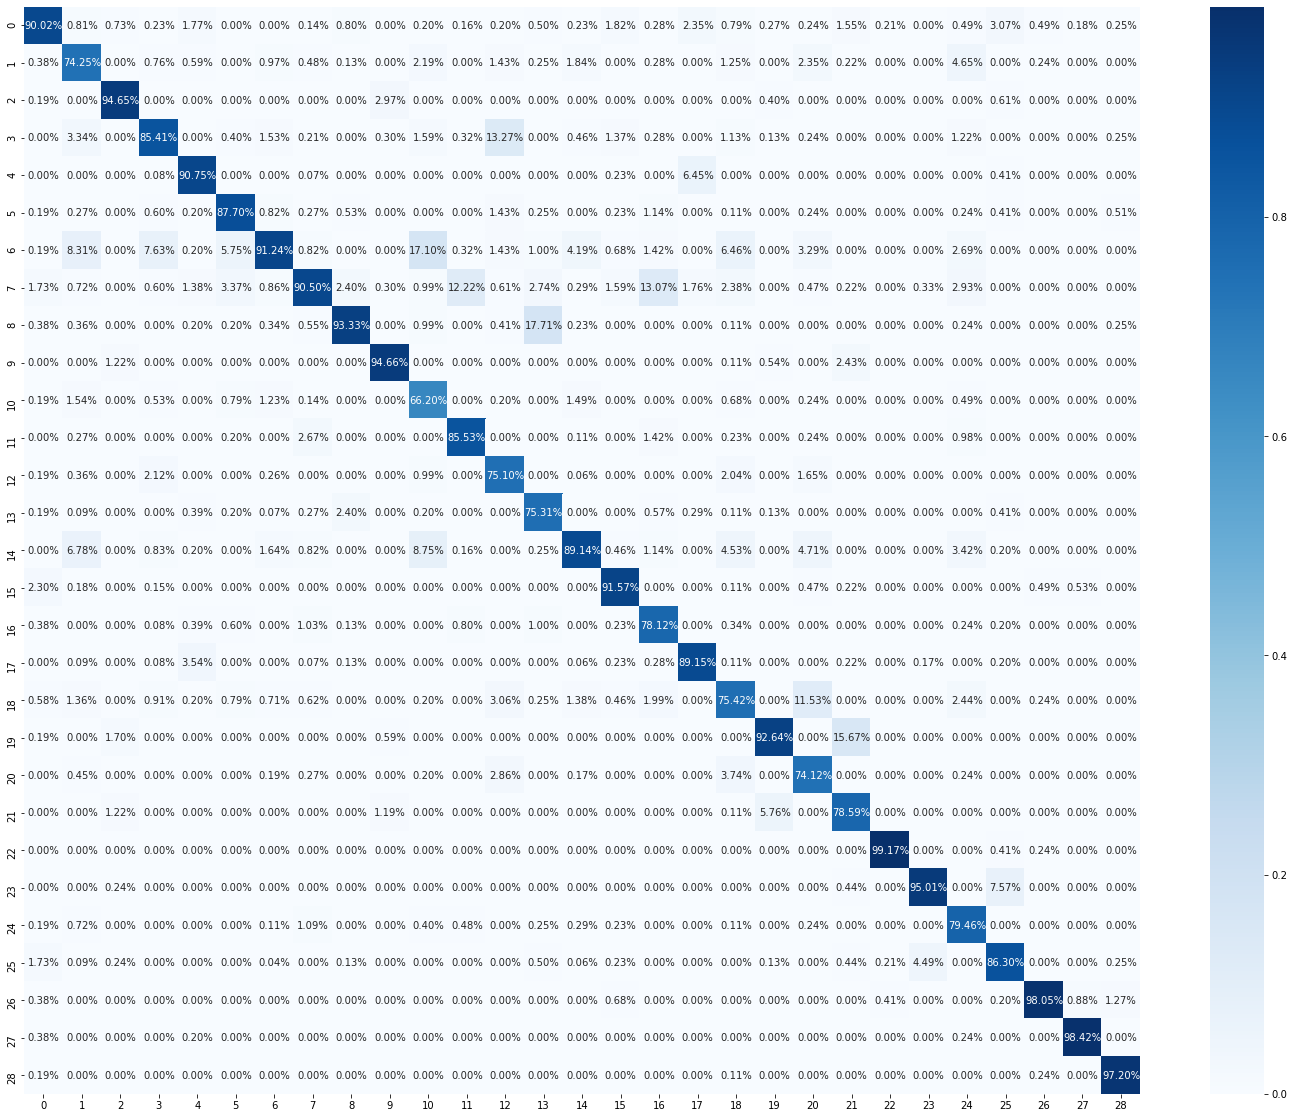

In [65]:
plt.figure(figsize = (25,20))
sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.2%', cmap='Blues')

In [71]:
print(classification_report(prediction, y_test_array))

              precision    recall  f1-score   support

           1       0.90      0.83      0.86       566
           2       0.74      0.85      0.79       965
           4       0.95      0.96      0.95       406
           5       0.85      0.85      0.85      1322
           6       0.91      0.94      0.93       488
           7       0.88      0.88      0.88       505
           9       0.91      0.83      0.87      2946
          10       0.90      0.82      0.86      1612
          12       0.93      0.86      0.90       810
          13       0.95      0.94      0.94       340
          14       0.66      0.77      0.71       433
          16       0.86      0.90      0.88       589
          19       0.75      0.84      0.79       439
          21       0.75      0.89      0.82       339
          22       0.89      0.85      0.87      1822
          33       0.92      0.94      0.93       427
          35       0.78      0.88      0.83       314
          37       0.89    

An dieser Stelle überlassen wir Ihnen das Feld und möchten Sie dazu animieren die **Parameter anzupassen** und die Beschreibungen weiter zu verarbeiten, um entweder in Richtung robustes oder akkurates Modell zu forschen.

Nutzen Sie auch weitere **Modelle** und lassen Sie uns teilhaben, wie die Ergebnisse aussehen!

**Wir wünschen Ihnen viel Spaß und freuen uns Ihre Ergebnisse zu sehen!**